In [1]:
import os, sys
## add helpers to python path
if os.path.join('..','helpers') not in sys.path:
    sys.path.append(os.path.join('..','helpers'))

import pymongo as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re
from io import BytesIO
from PIL import Image, ImageFilter
import object_mask_utils as u
import socket
import glob

from skimage import io, img_as_float
import base64

from IPython.core.pylabtools import figsize, getfigs

from IPython.display import clear_output
import importlib
import time

from collections import Counter
import operator

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

### set up paths

In [2]:
# directory & file hierarchy
proj_dir = os.path.abspath('../../')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'data')
csv_dir = os.path.join(results_dir,'diagnosticity')
sketch_dir = os.path.abspath(os.path.join(csv_dir,'sketches'))
gallery_dir = os.path.abspath(os.path.join(csv_dir,'gallery'))
map_dir = os.path.abspath(os.path.join(csv_dir,'maps'))
mask_dir = os.path.join(csv_dir, 'object_masks')


## import dictionaries that map between shapenet ids and graphical conventions naming scheme
importlib.reload(u)
G2S = u.GC2SHAPENET
S2G = u.SHAPENET2GC

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

def clear_dir(path_to_dir, ext = 'png'):
    files = glob.glob(os.path.join(path_to_dir, '*'))
    if len(files) > 0:
        for f in files:
            if f.split('.')[-1]==ext:
                os.remove(f)
        print('Deleted {} {} files in {}'.format(ext, len(files), path_to_dir))
    else:
        print('{} already empty. Did not delete any files.'.format(path_to_dir))
    return path_to_dir

## create directories that don't already exist        
result = [make_dir_if_not_exists(i) for i in [results_dir,csv_dir,sketch_dir,gallery_dir, map_dir, mask_dir]]

### load in annotations dataframe

In [3]:
T = pd.read_csv(os.path.join(csv_dir,'semantic_mapping_annotations_object.csv'))
print('There are {} records in T.'.format(T.shape[0]))    
print('These came from {} different refgames.'.format(T.gameid.nunique()))
print('These came from {} different annotation assignments.'.format(T.aID.nunique()))
print('These came from {} different worker IDs.'.format(T.wID.nunique()))
print(T.info(verbose=False,memory_usage='deep'))

There are 1921 records in T.
These came from 125 different refgames.
These came from 117 different annotation assignments.
These came from 110 different worker IDs.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1921 entries, 0 to 1920
Columns: 18 entries, _id to wID
dtypes: float64(3), int64(4), object(11)
memory usage: 15.9 MB
None


### get average heatmap for each pair of objects

In [4]:
object_pair_map_dir = os.path.join(map_dir,'object_pair_maps')
pair_gallery_dir = os.path.join(gallery_dir,'object_pair_gallery')
target_map_dir = os.path.join(map_dir,'target_object_maps')
target_gallery_dir = os.path.join(gallery_dir,'target_object_gallery')
result = [make_dir_if_not_exists(i) for i in [object_pair_map_dir, target_map_dir, pair_gallery_dir, target_gallery_dir]]

In [5]:
start = time.time()
## apply preprocessing to get base heatmaps
ims = T.apply(lambda x: Image.open(BytesIO(base64.b64decode(x['paintCanvasPng']))), axis=1)
print('Finished converting png strings to PIL Images. {} seconds elapsed.'.format(np.round(time.time() - start,3)))
imsb = ims.apply(lambda x: x.convert('RGB'))
print('Finished converting to RGB. {} seconds elapsed.'.format(np.round(time.time() - start,3)))
## add arrays to the big T dataframe
T = T.assign(arrs = imsb.apply(lambda x: np.array(x).astype(np.uint16)))
T = T.assign(valid_imsize = T.apply(lambda x: True if x['arrs'].shape[0]==300 else False, axis=1))
print('Finished adding image arrays to big dataframe. {} seconds elapsed.'.format(np.round(time.time() - start,3)))
## filter for images that have correct image size (300x300)
T = T[T['valid_imsize']==True]
## add identifier for (context_id, pair_id) combinations
T['target_id'] = T.apply(lambda x: x['targetChair'].split('/')[-1].split('.')[0],axis=1)
T['foil_id'] = T.apply(lambda x: x['comparisonChair'].split('/')[-1].split('.')[0],axis=1)
T = T.assign(context_target_foil = (T.apply(lambda x: '{}_{}_{}'
                                                 .format(x['context_id'],x['target_id'], x['foil_id']), axis=1)))
end = time.time()
print('{} seconds elapsed for image preprocessing.'.format(np.round(end-start,3)))

# NB:
# For each context containing 4 chairs, 6 pairs x 2 directions = 12 directed pairs
# x 4 contexts (diningA, diningB, waitingA, waitingB) 
# = 48 context_target_foils

## create H dictionary for each context_target_foil (each pair of objects)
H = dict() # diagnosticity map for this pair of objects
A = dict() # number of times this pair was annotated
for name, group in T.groupby('context_target_foil'):
    print('Extracting diagnosticity map for {}'.format(name))
    combined = np.mean(np.stack(np.array(group['arrs']),axis=3), axis=3)
    A[name] = group.shape[0]
    H[name] = (Image.fromarray((u.minmaxnorm(combined) * 255)
                              .astype(np.uint8))
                              .filter(ImageFilter.GaussianBlur(radius=1))
                              .convert('L')) 
    
    # save images out as PNG
    out_path = os.path.join(object_pair_map_dir,'{}.png'.format(name))
    H[name].save(out_path)
    clear_output(wait=True)    
    
end = time.time()
print('{} seconds elapsed for extracting diagnosticity maps for each object pair.'.format(np.round(end-start,3)))    
print('Done!')

4.912 seconds elapsed for extracting diagnosticity maps for each object pair.
Done!


In [6]:
## render gallery of object-pair-level diagnosticity maps
importlib.reload(u)
u.render_object_pair_gallery(object_pair_map_dir, pair_gallery_dir)
print('Done!')

Done!


In [9]:
## now consolidate context_target_foil maps into single map for each target, J

## re-convert H into dataframe to make it easier to group by target
D = pd.DataFrame.from_dict(H, orient='index').reset_index()
D.columns=['context_target_foil','image']
D = D.assign(target = D.apply(lambda x: x['context_target_foil'].split('_')[1], axis=1))

## create J dict, that contains consolidated target diagnosticity maps
J = dict()
for name, group in D.groupby('target'):
    group = group.assign(arrs = group.apply(lambda x: np.array(x['image']).astype(np.uint16), axis=1))
    combined = np.mean(np.stack(np.array(group['arrs']),axis=2), axis=2)
    J[name] = (Image.fromarray((u.minmaxnorm(combined) * 255)
                              .astype(np.uint8))
                              .filter(ImageFilter.GaussianBlur(radius=1))
                              .convert('L'))   
    
    # save images out as PNG
    out_path = os.path.join(target_map_dir,'{}.png'.format(S2G[name]))
    J[name].save(out_path)
    print('Saved out PNG for {}'.format(name))
    clear_output(wait=True)    
print('Done!')

Done!


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fde73827b30>

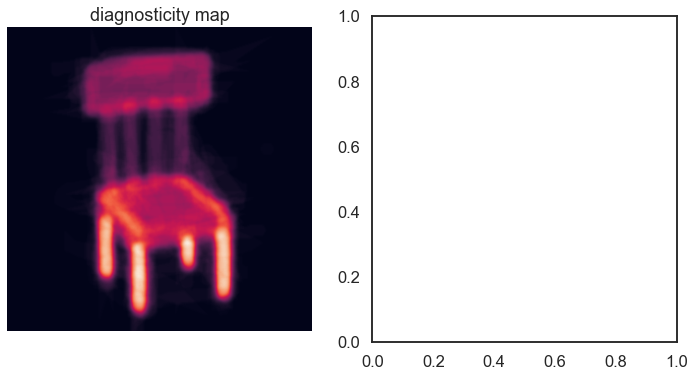

In [8]:
importlib.reload(u)
u.render_target_map_gallery(target_map_dir, target_gallery_dir)
print('Done!')